# Ensembling Feature Overview

This notebook provides an overview of the basic and advanced functionality of using ensemble methods in PySINDy. 

An interactive version of this notebook is available on binder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps

# Seed the random number generators for reproducibility
np.random.seed(100)

# define the Lorenz system
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

### Ensemble methods
One way to improve the robustness of a SINDy method is to use ensemble methods. Basically, we solve the regression problem many times on subsets (of size $n_{subset}$) of the time slices, generating $n_{models}$ models. All the coefficients are returned in model.coef_list and the average (bagging) can be used via np.mean(model.coef_list, axis=0) or the median (bragging) can be used via np.median(model.coef_list, axis=0). 

### The default number of models to generate is 20, and the default sampling strategy is to sample the entire time base with replacement, so that on average 60% or so of the data is seen. Default model is that the last fitted model is returned -- this is typically a bad approximation so use model.coef_list instead.

In [2]:
dt = .005
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
# add noise for more complexity
x_train = x_train + np.random.randn(x_train.shape[0], x_train.shape[1]) / 4.0

# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True)
model.print()
ensemble_coefs = model.coef_list

x' = 0.875 1 + -10.203 x + 10.056 y
y' = 26.791 x + -0.613 y + -0.973 x z
z' = 0.921 1 + -0.129 x + -2.636 z + 0.976 x y


### Library ensemble methods
Another way to do ensembling is to solve the regression problem on subsets of the candidate library, generating $p$ (the number of candidate terms) models. The syntax and code is a bit different, but the user-facing part is the same. Once again, the coefficients are returned in model.coef_list and the average can be used via np.mean(model.coef_list, axis=0). The default is still 20 generated models and the default sub-sampling is to chop one candidate term for each model.

In [3]:
# Instantiate and fit the SINDy model
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True)
model.print()
library_ensemble_coefs = model.coef_list

x' = -9.995 x + 9.971 y
y' = 0.494 1 + 25.391 x + -0.946 x z
z' = 0.237 1 + -2.674 z + 1.001 x y


### Now do both types of ensembling with multiple candidate drops!

In [4]:
double_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=double_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, ensemble=True, n_candidates_to_drop=2)
model.print()
double_ensemble_coefs = model.coef_list

x' = -0.741 1 + -10.070 x + 10.023 y
y' = -0.457 1 + 28.033 x + -0.975 y + -0.991 x z
z' = -0.474 1 + -2.660 z + 0.996 x y


### Alternatives to averaging (bagging) or taking the median (bragging) of the models: 
1. Weighted average of the coefficients, with weights corresponding to the mean-squared error with the testing (or training, if you like) $\dot{\mathbf{X}}$.
2. Define a function that does small integration forward of all the potential models for a bunch of a random initial conditions and chop any unstable models. Then repeat bagging or bragging.

In [5]:
from sklearn.metrics import mean_squared_error

def weighted_coefficient_average(coef_list, x_test, dt, optimizer):
    mse = np.zeros(np.shape(coef_list)[0])
    for i in range(np.shape(coef_list)[0]):
        optimizer.coef_ = np.asarray(coef_list)[i, :, :]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
    avg = np.average(coef_list, axis=0, weights=mse)
    coef_subtracted = np.zeros(np.shape(coef_list))
    for i in range(np.shape(coef_list)[0]):
        coef_subtracted[i, :, :] = np.asarray(coef_list)[i, :, :] - avg
    std = np.sqrt(np.average(coef_subtracted ** 2, axis=0, weights=mse))
    return avg, std

e_wavg, e_wstd = weighted_coefficient_average(ensemble_coefs, x_test, dt, ensemble_optimizer)
l_wavg, l_wstd = weighted_coefficient_average(library_ensemble_coefs, x_test, dt, library_ensemble_optimizer) 

def integration_metric(coef_list, optimizer):
    t_test = np.arange(0, 2, 0.01)    
    # Try 5 test trajectories
    for k in range(5):
        x0_test = (np.random.rand(3) - 0.5) * 10
        x_test = odeint(lorenz, x0_test, t_test)  
        for i in range(np.shape(coef_list)[0]):
            optimizer.coef_ = coef_list[i, :, :]
            x_test_sim = model.simulate(x0_test, t_test)
            if np.any(np.abs(x_test_sim) > 100):
                print('unstable model!')
                coef_list[i, :, :] = 0.0
    return coef_list

stable_ensemble_coefs = integration_metric(np.asarray(ensemble_coefs), ensemble_optimizer)
stable_library_ensemble_coefs = integration_metric(np.asarray(library_ensemble_coefs), library_ensemble_optimizer)

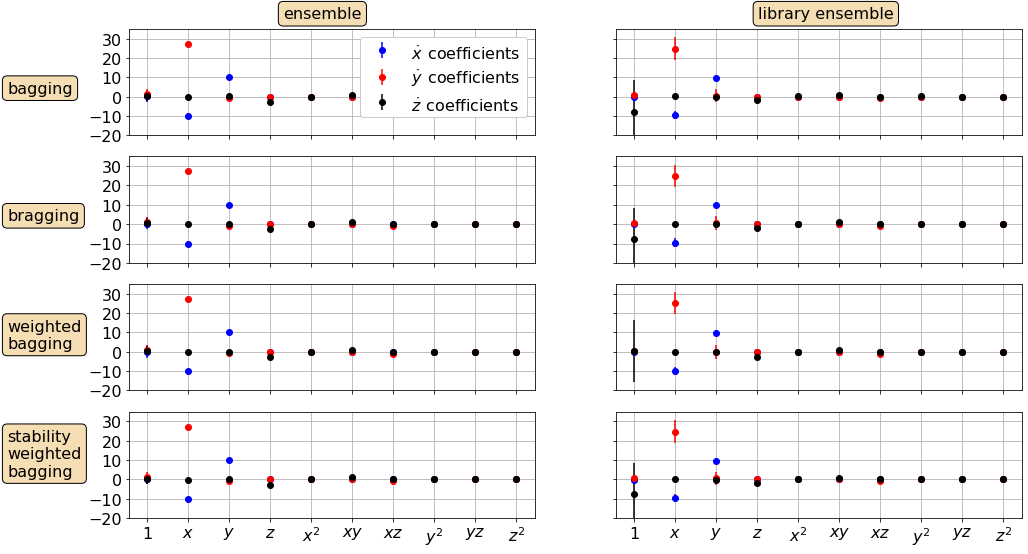

In [6]:
# Plot bagging results with error bars
coef_types = [np.mean(ensemble_coefs, axis=0), 
              np.mean(library_ensemble_coefs, axis=0), 
              e_wavg,
              l_wavg,
              np.median(ensemble_coefs, axis=0),
              np.median(library_ensemble_coefs, axis=0),
              np.mean(stable_ensemble_coefs, axis=0), 
              np.mean(stable_library_ensemble_coefs, axis=0), 
             ]
coef_stds = [np.std(ensemble_coefs, axis=0), 
             np.std(library_ensemble_coefs, axis=0), 
             e_wstd,
             l_wstd,
             np.std(ensemble_coefs, axis=0), 
             np.std(library_ensemble_coefs, axis=0), 
             np.std(stable_ensemble_coefs, axis=0), 
             np.std(stable_library_ensemble_coefs, axis=0), 
             ]
colors = ['b', 'r', 'k']
props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
textstrs = ['bagging', 'bragging', 'weighted\nbagging', 'stability\nweighted\nbagging']
plt.figure(figsize=(16, 9))
for k, coefs in enumerate(coef_types):
    coef_std = coef_stds[k]
    plt.subplot(4, 2, k + 1)
    for i in range(coefs.shape[0]):
        plt.errorbar(range(coefs.shape[1]), coefs[i, :], yerr=coef_std[i, :], 
                     fmt='o', color=colors[i], label='$\dot ' + feature_names[i] + '_{}$' + ' coefficients')
    ax = plt.gca()
    ax.set_xticks(range(10))
    if k >= 6:
        xticknames = model.get_feature_names()
        for i in range(10):
            xticknames[i] = '$' + xticknames[i] + '$'
        ax.set_xticklabels(xticknames, verticalalignment='top')
    else:
        ax.set_xticklabels([])
    plt.ylim(-20, 35)
    if k == 0:
        plt.legend(fontsize=16, framealpha=1.0, loc='upper right')
        ax.text(0.38, 1.1, 'ensemble', transform=ax.transAxes, fontsize=16, bbox=props)
    if k == 1:
        ax.text(0.35, 1.1, 'library ensemble', transform=ax.transAxes, fontsize=16, bbox=props)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    ax.set_yticks([-20, -10, 0, 10, 20, 30])
    if k % 2 == 0:
        textstr = textstrs[k // 2]
        ax.text(-0.3, 0.4, textstr, transform=ax.transAxes, fontsize=16, bbox=props)
    else:
        ax.set_yticklabels([])
plt.savefig('ensemble_summary.pdf')

### Even more advanced use of ensembling. We will loop through all the optimizers with ensembling and numerically calculate if the resulting models are stable (no unbounded trajectories) for any initial condition! The stability check relies on some analytic results about energy-preserving flows like the Lorenz system.

In [7]:
# Define some setup and plotting functions
# Build the energy-preserving quadratic nonlinearity constraints
# for ConstrainedSR3 and TrappingSR3 optimizer
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1)*(r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix
    

# Make the projection tensors used for the algorithm
def make_Ptensor(r):
    N = int((r ** 2 + 3 * r) / 2.0)

    # delta_{il}delta_{jk}
    PL_tensor = np.zeros((r, r, r, N))
    PL_tensor_unsym = np.zeros((r, r, r, N))
    for i in range(r):
        for j in range(r):
            for k in range(r):
                for l in range(N):
                    if i == l and j == k:
                        PL_tensor_unsym[i, j, k, l] = 1.0

    # Now symmetrize PL
    for i in range(r):
        for j in range(N):
            PL_tensor[:, :, i, j] = 0.5 * (PL_tensor_unsym[:, :, i, j] + PL_tensor_unsym[:, :, i, j].T)

    # if j == k, delta_{il}delta_{N-r+j,n}
    # if j != k, delta_{il}delta_{r+j+k-1,n}
    PQ_tensor = np.zeros((r, r, r, r, N))
    for i in range(r):
        for j in range(r):
            for k in range(r):
                for l in range(r):
                    for n in range(N):
                        if (j == k) and (n == N - r + j) and (i == l):
                            PQ_tensor[i, j, k, l, n] = 1.0
                        if (j != k) and (n == r + j + k - 1) and (i == l):
                            PQ_tensor[i, j, k, l, n] = 1.0 / 2.0
        
    return PL_tensor_unsym, PL_tensor, PQ_tensor
    

# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8,8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 'r')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 'k')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.savefig(filename + '_3d.pdf')

In [8]:
dt = 0.005
T = 40
t = np.arange(0, T + dt, dt)
r = 3
PL_tensor_unsym, PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
# initial value of the training trajectories
x0 = [1, -1, 20]
# sparsity thresholds to try
thresholds = [0.0]
# going to sample from Gaussians with variance 4
variance = 1.0
# define the clean training data
x_orig = odeint(lorenz, x0, t)
noise = np.random.normal(0.0, variance, x_orig.shape)
x_train = x_orig + noise
x0_test = (np.random.rand(3) - 0.5) * 200

# Initialize quadratic SINDy library, with custom ordering to be consistent with the constraint
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
feature_names = ['x', 'y', 'z']

# loop over threshold list
opt_coef_list = np.zeros((8, 20, 3, 9))
for i in range(8):
    print(i)
    if i == 0: 
        sindy_opt = ps.STLSQ(threshold=0, normalize_columns=True, max_iter=100)
    if i == 1: 
        sindy_opt = ps.SR3(threshold=0, normalize_columns=True, thresholder='l0', max_iter=500)
    if i == 2:
        sindy_opt = ps.SR3(threshold=0, normalize_columns=True, thresholder='l1', max_iter=500)
    if i == 3:
        sindy_opt = ps.SSR(normalize_columns=True, L0_penalty=1e-3)
    if i == 4:
        sindy_opt = ps.SSR(normalize_columns=True, criteria='model_residual', L0_penalty=1e-3)
    if i == 5:
        sindy_opt = ps.FROLS(normalize_columns=True, L0_penalty=1e-3)
    if i == 6:
        sindy_opt = ps.ConstrainedSR3(threshold=0, max_iter=5000, tol=1e-10,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature")
    if i == 7:
        eta = 1.0e-1
        alpha_m = 5e-2 * eta
        alpha_A = 1.0 * eta
        sindy_opt = ps.TrappingSR3(threshold=0, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, 
                           tol_m=1e-10,
                           PL=PL_tensor, PQ=PQ_tensor, max_iter=5000, tol=1e-10,
                           gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           )
    model = ps.SINDy(
        feature_names=feature_names,
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t, ensemble=True)
    opt_coef_list[i, :, :, :] = model.coef_list
    model.print()

0
x' = -0.813 x + 3.782 y + -0.376 z + 0.010 xy + -0.236 xz + 0.152 yz + -0.080 xx + 0.020 yy + 0.010 zz
y' = 19.083 x + 5.526 y + -0.067 z + -0.010 xy + -0.746 xz + -0.189 yz + -0.066 xx + 0.013 yy + 0.011 zz
z' = -4.725 x + 2.582 y + -3.184 z + 0.980 xy + 0.128 xz + -0.074 yz + -0.128 xx + 0.069 yy + 0.027 zz
1


/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarn

x' = 1.128 x + 5.194 y + -0.457 z + -0.248 xy + -0.291 xz + 0.100 yz + 0.080 xx + 0.152 yy + 0.011 zz
y' = 17.296 x + 4.613 y + -0.700 z + 0.132 xy + -0.700 xz + -0.143 yz + -0.203 xx + 0.001 yy + 0.037 zz
z' = -1.537 x + 1.455 y + -2.961 z + 0.650 xy + 0.080 xz + -0.075 yz + 0.096 xx + 0.188 yy + 0.011 zz
2


/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:314: ConvergenceWarn

x' = 3.208 x + 1.494 y + 0.156 z + -0.337 xy + -0.341 xz + 0.229 yz + 0.216 xx + 0.150 yy + -0.016 zz
y' = 16.328 x + 5.327 y + 0.113 z + 0.113 xy + -0.666 xz + -0.173 yz + -0.040 xx + -0.071 yy + -0.001 zz
z' = -2.018 x + 1.318 y + -2.586 z + 0.934 xy + 0.050 xz + -0.040 yz + -0.056 xx + 0.049 yy + 0.007 zz
3
x' = -3.050 x + 6.384 y + -0.135 z + -0.275 xy + -0.174 xz + 0.083 yz + 0.161 xx + 0.118 yy + -0.003 zz
y' = 20.318 x + 4.142 y + -0.870 z + 0.296 xy + -0.784 xz + -0.149 yz + -0.335 xx + -0.061 yy + 0.040 zz
z' = -6.340 x + 4.883 y + -2.865 z + 0.763 xy + 0.188 xz + -0.166 yz + 0.039 xx + 0.134 yy + 0.012 zz
4
x' = -1.702 x + 5.052 y + -0.579 z + 0.151 xy + -0.205 xz + 0.105 yz + -0.194 xx + -0.010 yy + 0.029 zz
y' = 19.575 x + 3.648 y + -0.165 z + -0.105 xy + -0.787 xz + -0.110 yz + 0.049 xx + 0.055 yy + 0.010 zz
z' = -2.789 x + 1.612 y + -2.571 z + 0.940 xy + 0.078 xz + -0.051 yz + -0.010 xx + 0.014 yy + 0.003 zz
5
x' = -2.032 x + 4.978 y + 0.683 z + -0.084 xy + -0.239 xz + 0.

/Users/alankaptanoglu/pysindy/pysindy/optimizers/constrained_sr3.py:382: ConvergenceWarning: SR3._reduce did not converge after 5000 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/constrained_sr3.py:382: ConvergenceWarning: SR3._reduce did not converge after 5000 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/constrained_sr3.py:382: ConvergenceWarning: SR3._reduce did not converge after 5000 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/constrained_sr3.py:382: ConvergenceWarning: SR3._reduce did not converge after 5000 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/constrained_sr3.py:382: ConvergenceWarning: SR3._reduce did not converge after 5000 iterations.
  ConvergenceWarning,
/Users/alankaptanoglu/pysindy/pysindy/optimizers/constrained_sr3.py:382: ConvergenceWarning: SR3._reduce did not converge after 5000 iterations.
  ConvergenceWarning

x' = -3.251 x + 6.307 y + 0.138 z + 0.069 xy + -0.163 xz + 0.068 yz + -0.046 yy + -0.005 zz
y' = 18.169 x + 4.837 y + -0.187 z + 0.046 xy + -0.738 xz + -0.140 yz + -0.069 xx + 0.011 zz
z' = -0.040 x + 0.067 y + -2.835 z + 0.670 xy + 0.005 xz + -0.011 yz + 0.163 xx + 0.140 yy
7
 Iteration | Data Error | Stability Error |   L1 Error
           0  2.41101e+08  1.15653e+03  0.00000e+00
         500  2.41101e+08  4.77971e+00  0.00000e+00
        1000  2.41101e+08  6.74114e-01  0.00000e+00
        1500  2.41101e+08  1.69699e-01  0.00000e+00
        2000  2.41101e+08  5.26223e-02  0.00000e+00
        2500  2.41101e+08  1.80225e-02  0.00000e+00
        3000  2.41101e+08  6.51150e-03  0.00000e+00
        3500  2.41101e+08  2.42573e-03  0.00000e+00
        4000  2.41101e+08  9.20209e-04  0.00000e+00
        4500  2.41101e+08  3.52941e-04  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  2.37270e+08  1.19892e+03  0.00000e+00
         500  2.37270e+08  1.94241e+00  0.00000e+00
        1000  2.37270e+08  8.88048e-02  0.00000e+00
        1500  2.37270e+08  6.21521e-03  0.00000e+00
        2000  2.37270e+08  4.79541e-04  0.00000e+00
        2500  2.37270e+08  3.79784e-05  0.00000e+00
        3000  2.37270e+08  3.02976e-06  0.00000e+00
        3500  2.37270e+08  2.42197e-07  0.00000e+00
        4000  2.37270e+08  1.93723e-08  0.00000e+00
        4500  2.37270e+08  1.54976e-09  0.00000e+00
x' = -0.545 x + 5.644 y + -0.026 z + 0.112 xy + -0.224 xz + 0.075 yz + -0.059 yy + -0.004 zz
y' = 15.031 x + 5.936 y + 0.056 z + 0.059 xy + -0.636 xz + -0.191 yz + -0.112 xx + 0.006 zz
z' = 0.373 x + -0.241 y + -2.892 z + 0.561 xy + 0.004 xz + -0.006 yz + 0.224 xx + 0.191 yy


/Users/alankaptanoglu/pysindy/pysindy/optimizers/trapping_sr3.py:631: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  ConvergenceWarning,


In [9]:
# Import simulated annealing algorithm for numerically computing the stability of these models
from scipy.optimize import dual_annealing as anneal_algo

# define the objective function to be minimized by simulated annealing
def obj_function(m, L_obj, Q_obj):
    As = L_obj - np.tensordot(m, Q_obj,axes=([0], [0]))
    eigvals, eigvecs = np.linalg.eigh(As)
    return(eigvals[-1])

# Search between -500, 500 for each component of m
boundvals = np.zeros((r, 2))
boundmax = 500
boundmin = -500
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax
num_stable = np.zeros(8, dtype=int)

# Run through all the models and check stability
for i in range(8):
    for j in range(10):
        Xi = opt_coef_list[i, j, :, :]
        L = np.tensordot(PL_tensor_unsym, Xi.T, axes=([3, 2], [0, 1]))
        Q = np.tensordot(PQ_tensor, Xi.T, axes=([4, 3], [0, 1]))
        Ls = 0.5 * (L + L.T)
        algo_sol = anneal_algo(obj_function, bounds=boundvals, args=(Ls, Q), maxiter=200)
        opt_m = algo_sol.x
        opt_energy = algo_sol.fun
        # print out results if model is stable (opt_energy < 0)
        if opt_energy < 0:
            print(i, j, opt_energy, opt_m)
            num_stable[i] += 1
            
    # Check the stability of the mean coefficients for each optimizer
    coef_mean = np.mean(opt_coef_list[i, :, :, :], axis=0)
    Xi = coef_mean
    L = np.tensordot(PL_tensor_unsym, Xi.T, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi.T, axes=([4, 3], [0, 1]))
    Ls = 0.5 * (L + L.T)
    algo_sol = anneal_algo(obj_function, bounds=boundvals, args=(Ls, Q), maxiter=200)
    opt_m = algo_sol.x
    opt_energy = algo_sol.fun
    opt_result = algo_sol.message
    if opt_energy < 0:
        print(i, 'mean: ', opt_energy, opt_m)
        
    # Check the stability of the median coefficients for each optimizer
    coef_median = np.median(opt_coef_list[i, :, :, :], axis=0)
    Xi = coef_median
    L = np.tensordot(PL_tensor_unsym, Xi.T, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi.T, axes=([4, 3], [0, 1]))
    Ls = 0.5 * (L + L.T)
    algo_sol = anneal_algo(obj_function, bounds=boundvals, args=(Ls, Q), maxiter=200)
    opt_m = algo_sol.x
    opt_energy = algo_sol.fun
    opt_result = algo_sol.message
    if opt_energy < 0:
        print(i, 'median: ', opt_energy, opt_m)

0 5 -2.193701311165197 [57.34738966 -4.23631992 36.11007986]
0 7 -3.0895305444084444 [500.         -17.82982287 277.21044997]
1 0 -7.5246055150481395 [500.         -32.32759424 323.28371796]
1 1 -1.3792959182940818 [43.1799835  -3.15412621 40.42380934]
1 2 -0.23815840983433173 [38.01747866  5.01917805 36.16202581]
1 3 -2.8742001573291445 [ 7.72715123 -3.7959974  41.11452253]
1 4 -1.6238731901935948 [20.91325872  0.63048727 34.97294413]
1 7 -0.9382628845486012 [23.40614055 -0.74559092 31.93368904]
1 9 -0.8243315361658088 [ 64.4311603  -23.32543844  44.67264198]
2 0 -1.5199874380749514 [ 58.65068332 -11.29381037  41.5357933 ]
2 4 -0.6582773480134756 [ 1.67655875  1.79029345 34.30661725]
2 6 -1.7468458845256918 [53.9106337  -5.99893633 34.64513432]
2 7 -1.5797403081435066 [ -4.56898292 -10.74097102  47.3501263 ]
3 0 -0.7845734145847775 [85.7056814  -3.86664217 30.94672536]
3 3 -0.5161607560444703 [ 5.48733072  3.77327743 37.76618578]
3 4 -2.752849675986458 [64.38498867  4.18856943 62.1690

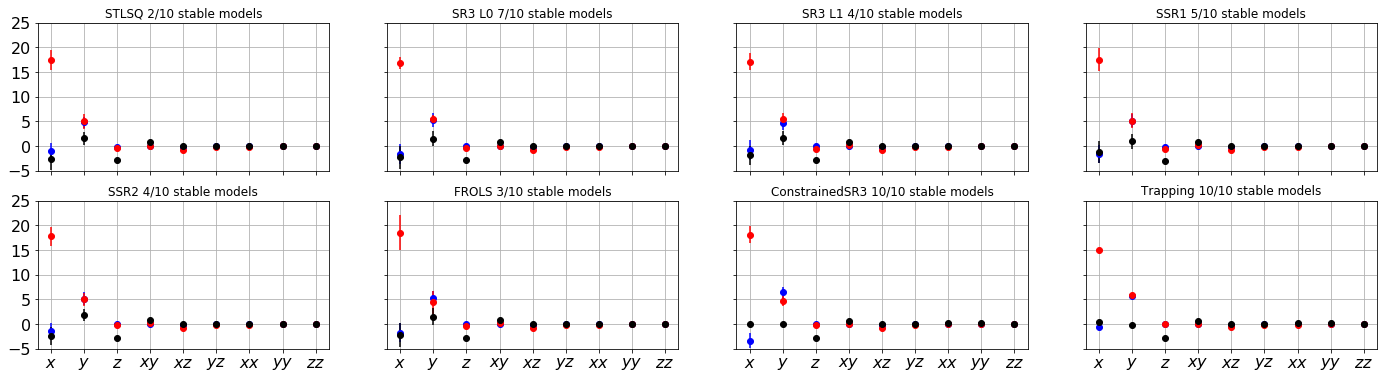

In [10]:
# Plot each optimizer results for the coefficients + error bars
colors = ['b', 'r', 'k']
plt.figure(figsize=(24, 6))
x_sims_mean = np.zeros((8, len(t), 3))
x_sims_median = np.zeros((8, len(t), 3))
opt_names = ['STLSQ', 'SR3 L0', 'SR3 L1', 'SSR1', 'SSR2', 'FROLS', 'ConstrainedSR3', 'Trapping']
for i in range(8):
    coef_mean = np.mean(opt_coef_list[i, :, :, :], axis=0)
    coef_median = np.median(opt_coef_list[i, :, :, :], axis=0)
    coef_std = np.std(opt_coef_list[i, :, :, :], axis=0)
    plt.subplot(2, 4, i + 1)
    for j in range(3):
        plt.errorbar(range(9), coef_mean[j, :], yerr=coef_std[j, :], fmt='o', color=colors[j])
    ax = plt.gca()
    ax.set_xticks(range(9))
    xticknames = model.get_feature_names()
    for j in range(9):
        xticknames[j] = '$' + xticknames[j] + '$'
    ax.set_xticklabels(xticknames, verticalalignment='top', fontsize=16)
    plt.grid(True)
    
    sindy_opt.coef_ = coef_mean
    x_sims_mean[i, :, :] = model.simulate(x0_test, t)
    sindy_opt.coef_ = coef_median
    x_sims_median[i, :, :] = model.simulate(x0_test, t)
    plt.ylim(-5, 25)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(opt_names[i] + ' ' + str(num_stable[i]) + '/10 stable models')
    if i != 0 and i != 4:
        ax.set_yticklabels([])
    if i < 4:
        ax.set_xticklabels([])
plt.savefig('ensemble_stability_summary.pdf')